# Case study 2: The T signaling pathway

In [1]:
import eliater
from eliater.examples import t_cell_signaling_example as example
from y0.dsl import P, Variable

eliater.version_df()

,key,value
0,eliater,0.0.3-dev-c9b18470
1,y0,0.2.9-dev-06df659d
2,Run at,2024-01-29 13:45:34


In [2]:
treatment = RAF = Variable("Raf")
outcome = ERK = Variable("Erk")
PKC = Variable("PKC")
MEK = Variable("Mek")

This is case study 2 in this paper: Eliater: an open source software for causal query estimation from observational measurements of biomolecular networks. The Figure below is the protein signalling network (G) of the cell signaling pathway presented in (Sachs et al., 2005). It models the molecular
mechanisms and regulatory processes involved in T cell activation, proliferation, and function.

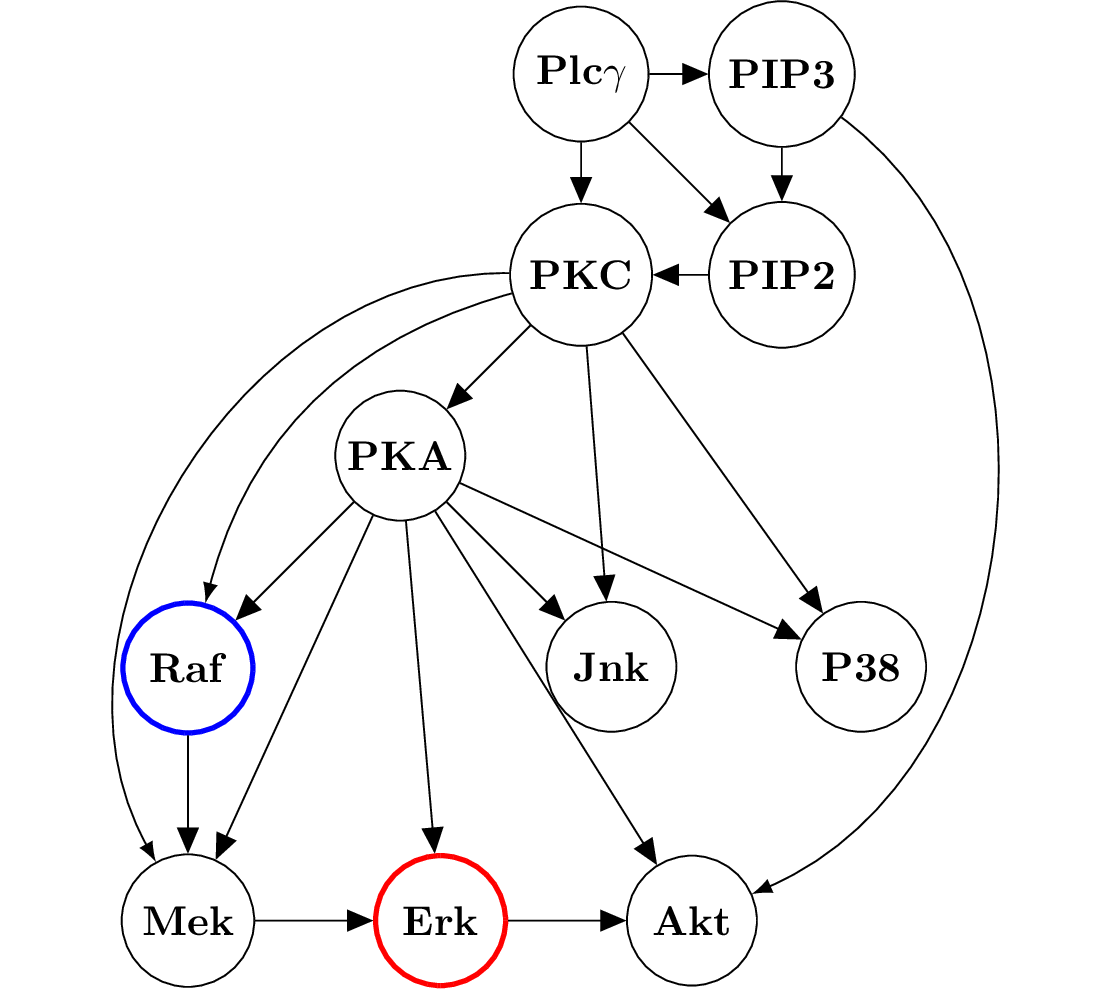

In [3]:
from IPython.display import Image

Image(filename="../img/Tsignaling.png", width=500, height=500)

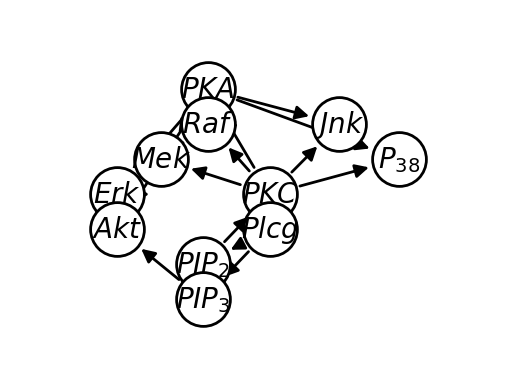

In [4]:
graph = example.graph
graph.draw()

The observational data consisted of quantitative multivariate flow cytometry measurements of phosphorylated proteins derived from thousands of individual primary immune system cells. The cells were subjected to general stimuli meant to activate the desired paths. The distributions of measurements of individual proteins were skewed, and pairs of proteins exhibited nonlinear relationships. To account for that, the data were binned into
two levels corresponding to low, and high concentrations using Hartemink’s approach (Hartemink, 2001) to preserve
the dependence structure of the original data.

In [5]:
data = example.data
data

,Raf,Mek,Plcg,PIP2,PIP3,Erk,Akt,PKA,PKC,P38,Jnk
0,0,0,0,1,1,1,0,1,1,1,1
1,0,1,1,1,1,1,1,1,1,1,1
2,1,0,0,1,1,1,1,1,1,0,0
3,1,0,0,1,1,1,1,1,1,0,0
4,0,0,1,1,0,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
848,1,0,0,0,1,1,1,0,1,0,0
849,0,0,0,1,1,1,1,1,1,1,0
850,1,1,0,1,1,1,0,1,1,0,0
851,1,0,0,1,1,1,1,0,1,1,0


In [6]:
eliater.step_1_notebook(graph=graph, data=data)

## Step 1: Checking the ADMG Structure

Of the 35 d-separations implied by the ADMG's structure, only 6 (17.14%) rejected the null hypothesis for the cressie_read test at p<0.01.

Since this is less than 30%, Eliater considers this minor and leaves the ADMG unmodified. Finished in 1.23 seconds.


| left   | right   | given        |    stats |           p |   dof |       p_adj | p_adj_significant   |
|:-------|:--------|:-------------|---------:|------------:|------:|------------:|:--------------------|
| Erk    | PIP2    | PKC          |  86.6709 | 0           |     2 | 0           | True                |
| Erk    | PIP3    | PKC          | 447.612  | 0           |     2 | 0           | True                |
| Jnk    | P38     | PKA;PKC      | 174.846  | 0           |     4 | 0           | True                |
| Plcg   | Raf     | PKC          | 245.416  | 0           |     2 | 0           | True                |
| Mek    | Plcg    | PKC          | 206.312  | 0           |     2 | 0           | True                |
| Akt    | PKC     | Mek;PIP3;PKA |  35.6955 | 1.99628e-05 |     8 | 0.000598884 | True                |

Out of 35 d-separations implied by the network, six failed. As the precentage of failed tests is below 30 percent, its effect on the estimation of causal query is minor. Hence, we proceed to the next step.

In [7]:
eliater.step_2_notebook(graph=graph, treatment=treatment, outcome=outcome)


## Step 2: Check Query Identifiability

The causal query of interest is the average treatment effect of $Raf$ on $Erk$, defined as: 
$\mathbb{E}[Erk \mid do(Raf=1)] - \mathbb{E}[Erk \mid do(Raf=0)]$.


Running the ID algorithm defined by [Identification of joint interventional distributions in recursive
semi-Markovian causal models](https://dl.acm.org/doi/10.5555/1597348.1597382) (Shpitser and Pearl, 2006)
and implemented in the $Y_0$ Causal Reasoning Engine gives the following estimand:

$\sum\limits_{Mek, PIP_2, PIP_3, PKA, PKC, Plcg} P(Erk | Mek, PIP_2, PIP_3, PKA, PKC, Plcg, Raf) P(Mek | PIP_2, PIP_3, PKA, PKC, Plcg, Raf) P(PIP_2 | PIP_3, Plcg) P(PIP_3 | Plcg) P(PKA | PIP_2, PIP_3, PKC, Plcg) P(PKC | PIP_2, PIP_3, Plcg) \sum\limits_{Erk, Mek, PIP_2, PIP_3, PKA, PKC, Raf} \sum\limits_{Akt, Jnk, P_{38}} P(Akt, Erk, Jnk, Mek, P_{38}, PIP_2, PIP_3, PKA, PKC, Plcg, Raf)$

Because the query is identifiable, we can proceed to Step 3.


## Step 3/4: Identify Nuisance Variables and Simplify the ADMG

The following 1 variables were identified as _nuisance_ variables,
meaning that they appear as descendants of nodes appearing in paths between
the treatment and outcome, but are not themselves ancestors of the outcome variable:

$Akt$

These variables are marked as "latent", then
the algorithm proposed in [Graphs for margins of Bayesian
networks](https://arxiv.org/abs/1408.1809) (Evans, 2016) and implemented in
the $Y_0$ Causal Reasoning Engine is applied to the ADMG to
simplify the graph. This minimally removes the latent variables and makes
further simplifications if the latent variables are connected by bidirected
edges to other nodes.


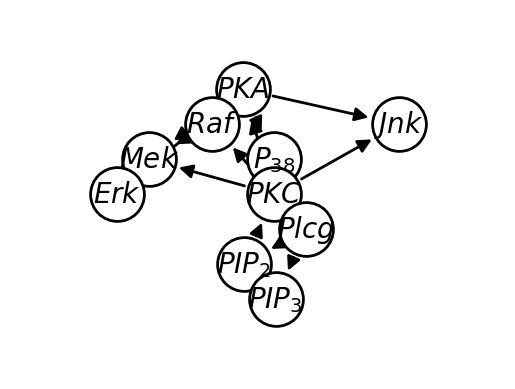

In [8]:
reduced_graph = eliater.step_3_notebook(graph=graph, treatment=treatment, outcome=outcome)

## Step 5: Estimate the query

Subsampling:   0%|          | 0/500 [00:00<?, ?it/s]

Estimating:   0%|          | 0/500 [00:00<?, ?it/s]

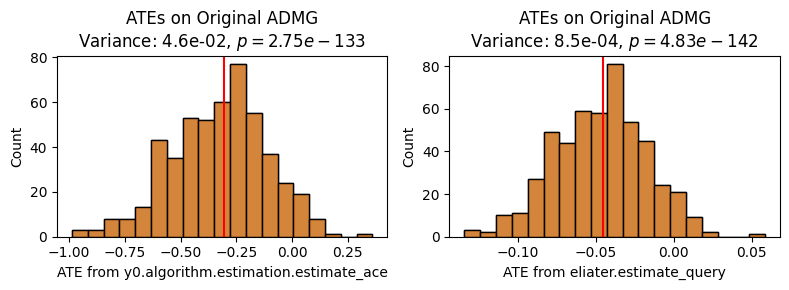

In [9]:
eliater.step_5_notebook_real(
    graph=graph, example=example, treatment=treatment, outcome=outcome, subsample_size=400
)

In [ ]:
# What do we need to say about this alternate query?
# estimate_ace(new_graph, treatments=PKC, outcomes=ERK, data=data)

# Test the data that Karen gave me

TODO: what is the context for these? what are these datasets, where do they come from? Why are they here?

In [ ]:
from eliater.data import load_sachs_continuous, load_sachs_test1, load_sachs_test2

data1 = load_sachs_test1()
data1.head()

In [ ]:
data2 = load_sachs_test2()
data2.head()

In [ ]:
data_continuous = load_sachs_continuous()
data_continuous.head()